In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#export

from exp.nb_02_callbacks import *
from exp.nb_02_anneal import *

# Early Stopping
## Better Callback cancellation

In [3]:
x_train, y_train, x_valid, y_valid = get_data(url=MNIST_URL)
train_ds = Dataset(x=x_train, y=y_train)
valid_ds = Dataset(x=x_valid, y=y_valid)
nh = 50
bs = 16
c  = y_train.max().item() + 1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs=bs), c=c)

In [5]:
#export

class Callback():
    _order = 0
    def set_runner(self, run):
        self.run = run
    def __getattr__(self, key):
        return getattr(self.run, key)
    
    @property
    def name(self):
        name = re.sub(pattern=r'Callback$', repl='', string=self.__class__.__name__)
        return camel2snake(name or "callback")
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f():
            return True
        return False
    
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0
        self.run.n_iter   = 0
        
    def after_batch(self):
        if not self.run.in_train:
            return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs = self.epoch
        self.model.train()
        self.run.in_train = True
        
    def begin_validate(self):
        self.model.eval()
        self.run.in_train = False
        
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass


In [6]:
#export

class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.cbs = [TrainEvalCallback()] + cbs
        self.stop = False
        
    @property
    def opt(self):
        return self.learner.opt
    @property
    def model(self):
        return self.learner.model
    @property
    def loss_func(self):
        return self.learner.loss_fn
    @property
    def data(self):
        return self.learner.data
    
    def one_batch(self, xb, yb):
        try:
            self.xb = xb
            self.yb = yb
            self("begin_batch")
            self.pred = self.model(self.xb)
            self("after_pred")
            self.loss = self.loss_func(self.pred, self.yb)
            self("after_loss") 
            if not self.in_train:
                return
            self.loss.backward()
            self("after_backward")
            self.opt.step()
            self("after_step")
            self.opt.zero_grad()
        except CancelBatchException:
            self("after_cancel_batch")
        finally:
            self("after_batch")

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb, yb in dl:
                self.one_batch(xb, yb)
        except CancelEpochException:
            self("after_cancel_epoch")

    def fit(self, epochs, learner):
        self.epochs = epochs
        self.learner = learner
        self.loss = torch.tensor(0.)
        
        try:
            for cb in self.cbs:
                cb.set_runner(self)
            self("begin_fit")
            for epoch in range(self.epochs):
                self.epoch = epoch
                if not self("begin_epoch"):
                    self.all_batches(self.data.train_dl)
                with torch.no_grad():
                    if not self("begin_validate"):
                        self.all_batches(self.data.valid_dl)
                self("after_epoch")
        except CancelTrainException:
            self("after_cancel_train")
        finally:
            self('after_fit')
            self.learner = None                                      ### <-- WHY this step???
            
    def __call__(self, cb_name):
        """This will always return 'False' because 'result' is initialized with 'False'
        Doing "and" operator with any value will give 'False'.
        This is designed behaviour because our exit/stop handeling is now carried by 'Exception'
        like CancelBatchException, CancelEpochException, CancelTrainException....
        """
        result = False
        for cb in sorted(self.cbs, key=lambda x: x._order):
            result = cb(cb_name) and result
        return result
    

In [55]:
class TestCallback(Callback):
    _order = 1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter >= 10:
            raise CancelTrainException()

In [56]:
learner = create_learner(model_func=get_model, loss_func=loss_func, data=data)
run = Runner(cbs=[TestCallback()])

In [57]:
run.fit(epochs=2, learner=learner)

0
1
2
3
4
5
6
7
8
9
10


## Other Callbacks

In [7]:
#export

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats = AvgStats(metrics=metrics, in_train=True)
        self.valid_stats = AvgStats(metrics=metrics, in_train=False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
    
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad():
            stats.accumulate(self.run)
            
    def after_epoch(self):
        print(f"epoch=[{self.epoch}/{self.epochs}]:\t"\
              f"{self.train_stats}\t"\
              f"{self.valid_stats}")
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs    = [[] for _ in self.opt.param_groups]
        self.losses = []
        
    def after_batch(self):
        if not self.in_train:
            return
        for pg, lr in zip(self.opt.param_groups, self.lrs):
            lr.append(pg["lr"])
        self.losses.append(self.loss.detach().cpu())                  ### transferring the batch loss to cpu and then appending it to the array
        
    def plot_lr(self, pgid=-1):
        plt.xlabel("param_groups")
        plt.ylabel("lrs")
        plt.plot(self.lrs[pgid])
        
    def plot_loss(self, skip_last=0):
        plt.xlabel("batch number")
        plt.ylabel("loss")
        plt.plot(self.losses[:(len(self.losses)-skip_last)])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [x.item() for x in self.losses]
        lrs = self.lrs[pgid]
        n = len(losses) - skip_last
        plt.xscale("log")
        plt.xlabel("lrs (log scale)")
        plt.ylabel("losses")
        plt.plot(lrs[:n], losses[:n])
        

class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs):
        self.pname = pname
        self.sched_funcs = sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list, tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)
    
    def set_param(self):
        assert len(self.sched_funcs) == len(self.opt.param_groups)
        for pg, f in zip(self.opt.param_groups, self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self):
        if self.in_train:
            self.set_param()


In [88]:
class LRFind(Callback):
    _order = 1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter = max_iter
        self.min_lr   = min_lr
        self.max_lr   = max_lr
        self.best_loss = 1e9
    def begin_batch(self):
        if not self.in_train:
            return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups:
            pg["lr"] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss:
            self.best_loss = self.loss
            

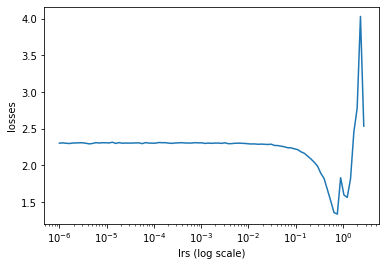

In [94]:
bs = 512
data = DataBunch(*get_dls(train_ds, valid_ds, bs=bs), c=c)
learner = create_learner(model_func=get_model, loss_func=loss_func, data=data)
run = Runner(cb_funcs=[LRFind, Recorder])
run.fit(epochs=2, learner=learner)
run.recorder.plot(skip_last=5)

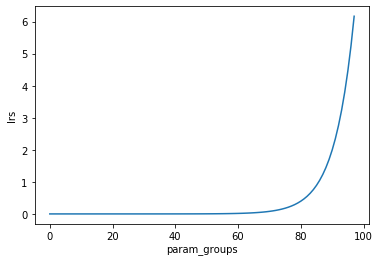

In [95]:
run.recorder.plot_lr()

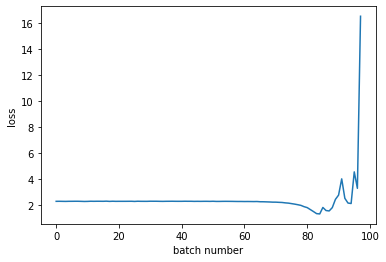

In [96]:
run.recorder.plot_loss()

# Export

In [8]:
!python notebook_to_script.py imflash217__03_early_stopping.ipynb

Converted imflash217__03_early_stopping.ipynb to exp/nb_03_early_stopping.py
Converted imflash217__03_early_stopping.ipynb to exp/nb_03_early_stopping.py
Converted imflash217__03_early_stopping.ipynb to exp/nb_03_early_stopping.py
Converted imflash217__03_early_stopping.ipynb to exp/nb_03_early_stopping.py
